In [45]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal', 
        'size'   : 18}

matplotlib.rc('font', **font)

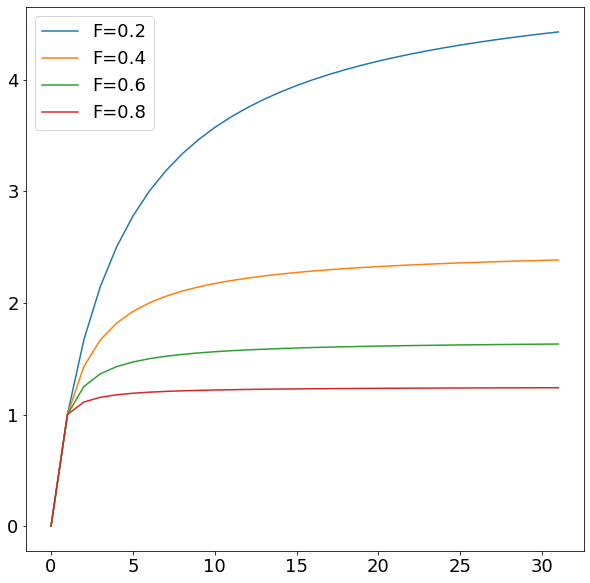

In [30]:
p = torch.from_numpy(np.array([_ for _ in range(32)]))

F = 0.2
y1 = 1 / (F + (1 - F) / p)

F = 0.4
y2 = 1 / (F + (1 - F) / p)

F = 0.6
y3 = 1 / (F + (1 - F) / p)

F = 0.8
y4 = 1 / (F + (1 - F) / p)


plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(p, y1, label='F=0.2')
plt.plot(p, y2, label='F=0.4')
plt.plot(p, y3, label='F=0.6')
plt.plot(p, y4, label='F=0.8')
plt.legend()
plt.show()

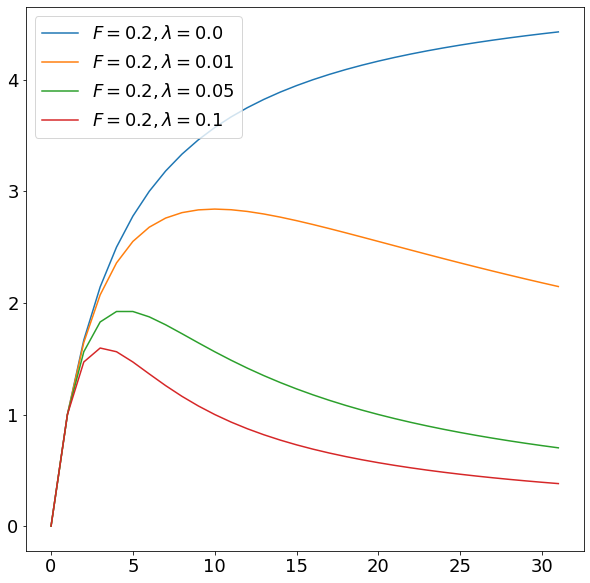

In [42]:
def amdahl_plus(F, lmd, p):
    return 1 / (F + (1 - F) * (1 / p + (p - 1) * lmd))

p = torch.from_numpy(np.array([_ for _ in range(32)]))

y1 = amdahl_plus(F=0.2, lmd=0.0, p=p)
y2 = amdahl_plus(F=0.2, lmd=0.01, p=p)
y3 = amdahl_plus(F=0.2, lmd=0.05, p=p)
y4 = amdahl_plus(F=0.2, lmd=0.1, p=p)


plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(p, y1, label='$F=0.2, \lambda=0.0$')
plt.plot(p, y2, label='$F=0.2, \lambda=0.01$')
plt.plot(p, y3, label='$F=0.2, \lambda=0.05$')
plt.plot(p, y4, label='$F=0.2, \lambda=0.1$')
plt.legend()
plt.show()

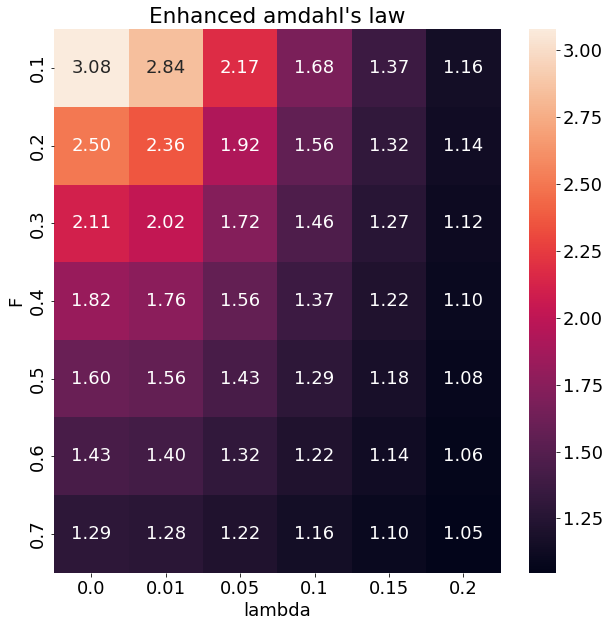

In [54]:
F = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
L = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]

out_f = []
out_l = []
out = []

df_data = []

for f in F:
    for l in L:
        df_data.append([f, l, amdahl_plus(F=f, lmd=l, p=4)])
df = pd.DataFrame(data=df_data, columns=['F', 'lambda', 'SpeedUp'])
    
vis = df.pivot('F', 'lambda', 'SpeedUp')
plt.title("Enhanced amdahl's law")
ax = sns.heatmap(vis, annot=True, fmt=".2f")

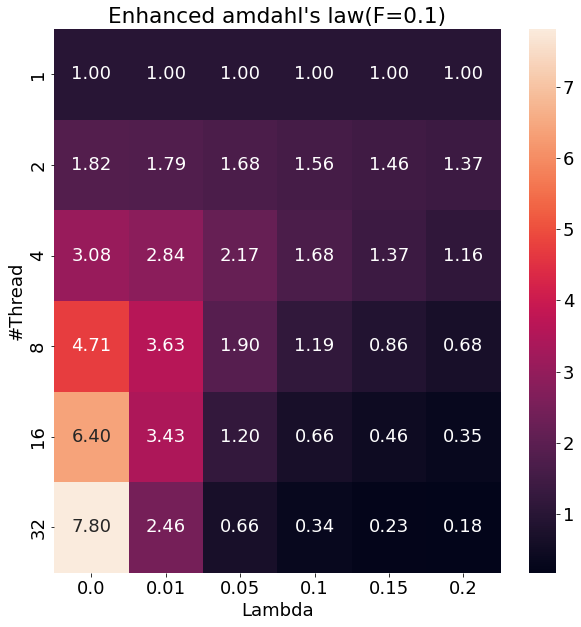

In [58]:
L = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]
P = [1, 2, 4, 8, 16, 32]

out_f = []
out_l = []
out = []

df_data = []

for l in L:
    for p in P:
        df_data.append([l, p, amdahl_plus(F=0.1, lmd=l, p=p)])
df = pd.DataFrame(data=df_data, columns=['Lambda', '#Thread', 'SpeedUp'])
    
vis = df.pivot('#Thread', 'Lambda', 'SpeedUp')
plt.title("Enhanced amdahl's law(F=0.1)")
ax = sns.heatmap(vis, annot=True, fmt=".2f")